# Subtract cancellation
When the subtracted value (a-b) is too small to a or b, the floating number presicion error due to the storage size limit become not-negligible.

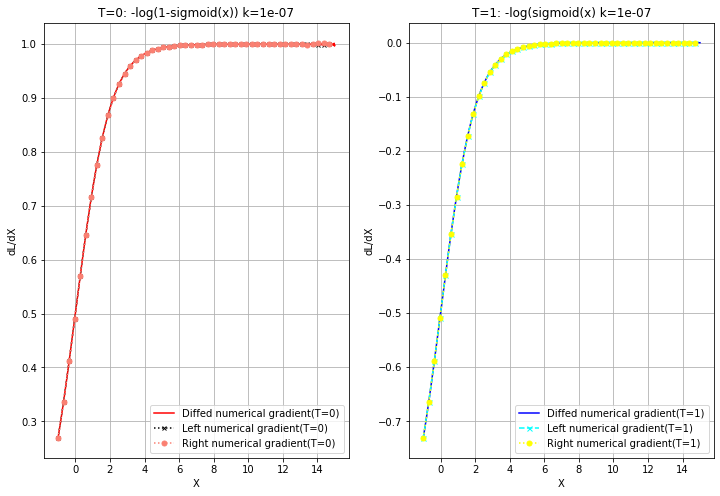

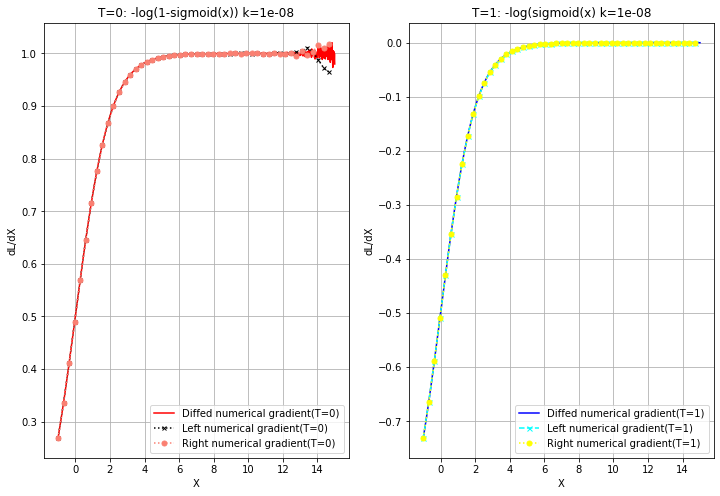

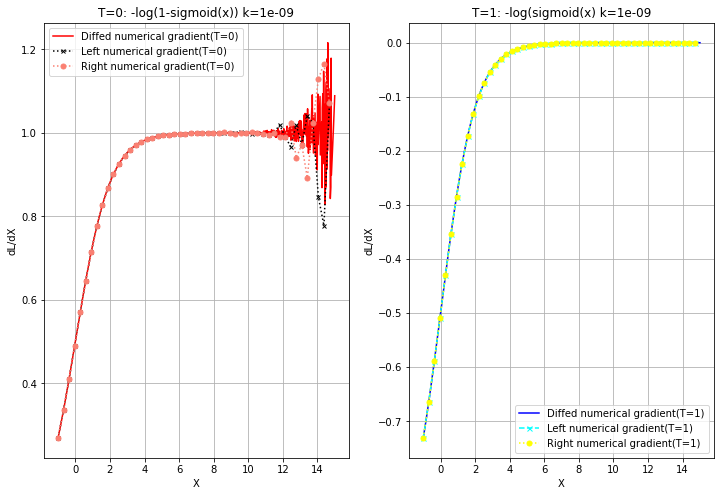

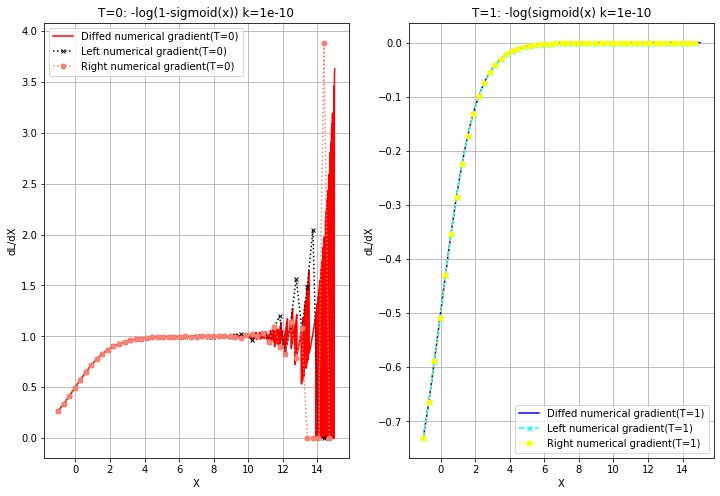

In [1]:
import inspect
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def __sigmoid(X):
    return 1 / (1 + np.exp(-1 * X))

def __sigmoid_reverse(y):
    """
    Args:
        y: y=sigmoid(x)
    Returns:
        x: x that gives y=sigmoid(x)
    """
    return np.log(y/(1-y))

def __sigmoid_gradient(X):
    Z = __sigmoid(X)
    return Z * (1.0 - Z)

def __logistic_log_loss(X: np.ndarray, T: np.ndarray, offset: float=0):
    return -(T * np.log(__sigmoid(X)+offset) + (1-T) * np.log(1-__sigmoid(X)+offset))

def __logistic_log_loss_gradient(X, T):
    Z = __sigmoid(X)
    return Z-T

def __numerical_jacobian(f, X, delta=1e-8) -> np.ndarray:
    X = np.array(X, dtype=float) if isinstance(X, (float, int)) else X
    J = np.zeros_like(X, dtype=float)
    assert (X.dtype == float), "X must be float type"
    assert delta > 0.0

    it = np.nditer(X, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp: float = X[idx]

        X[idx] = tmp + delta
        fx1: Union[np.ndarray, float] = f(X)  # f(x+h)

        assert not np.all(np.isnan(fx1)), \
            "numerical delta f(x+h) caused nan for f %s for X %s" \
            % (f, (tmp + delta))

        X[idx] = tmp - delta
        fx2: Union[np.ndarray, float] = f(X)  # f(x-h)
        assert not np.all(np.isnan(fx2)), \
            "numerical delta f(x-h) caused nan for f %s for X %s" \
            % (f, (tmp - delta))

        g: Union[np.ndarray, float] = (fx1 - fx2) / (2 * delta)
        assert (isinstance(g, np.ndarray) and g.size == 1) or isinstance(g, float), \
            "The f function needs to return scalar or shape () but %s" % g
        J[idx] = g
        X[idx] = tmp
        it.iternext()

    return J

def __gn(X, t, k):
    """Numerical gradient for logistic log loss"""
    return [
        __numerical_jacobian(lambda x: __logistic_log_loss(X=x, T=t, offset=k), x) 
        for x in X 
    ]

def t_0_loss(X):
    return [
        #logistic_log_loss(P=sigmoid(x), T=0)
        -np.log(1.0 - __sigmoid(x)) for x in X 
    ]

def t_1_loss(X):
    return [
        #logistic_log_loss(P=sigmoid(x), T=1)
        -np.log(__sigmoid(x)) for x in X 
    ]


def gn_plot(X, k):
    fig, axes = plt.subplots(1, 2, figsize=(12,8))

    # --------------------------------------------------------------------------------
    # T = 0
    # --------------------------------------------------------------------------------
    axes[0].plot(
        X,
        ((np.array(t_0_loss(X + k)) - np.array(t_0_loss(X - k))) / (2*k)),
        color='red', linestyle='solid',
        label="Diffed numerical gradient(T=0)"
    )
    axes[0].plot(
        X[0:-1:20],
        ((np.array(t_0_loss(X + k)) - np.array(t_0_loss(X))) / k)[0:-1:20],
        color='black', linestyle='dotted', marker='x', markersize=4,
        label="Left numerical gradient(T=0)"
    )
    axes[0].plot(
        X[0:-1:20],
        ((np.array(t_0_loss(X)) - np.array(t_0_loss(X - k))) / k)[0:-1:20],
        color='salmon', linestyle='dotted', marker='o', markersize=5,
        label="Right numerical gradient(T=0)"
    )

    axes[0].set_xlabel("X")
    axes[0].set_ylabel("dL/dX")
    axes[0].set_title(f"T=0: -log(1-sigmoid(x)) k={k}")
    axes[0].legend()
    axes[0].grid(True)

    # --------------------------------------------------------------------------------
    # T = 1
    # --------------------------------------------------------------------------------
    axes[1].plot(
        X,
        ((np.array(t_1_loss(X + k)) - np.array(t_1_loss(X - k))) / (2*k)),
        color='blue', linestyle='solid',
        label="Diffed numerical gradient(T=1)"
    )
    axes[1].plot(
        X[0:-1:20],
        ((np.array(t_1_loss(X + k)) - np.array(t_1_loss(X))) / k)[0:-1:20],
        color='cyan', linestyle='dashed', marker='x', markersize=5,
        label="Left numerical gradient(T=1)"
    )
    axes[1].plot(
        X[0:-1:20],
        ((np.array(t_1_loss(X)) - np.array(t_1_loss(X - k))) / k)[0:-1:20],
        color='yellow', linestyle='dotted', marker='o', markersize=5,
        label="Right numerical gradient(T=1)"
    )

    axes[1].set_xlabel("X")
    axes[1].set_ylabel("dL/dX")
    axes[1].set_title(f"T=1: -log(sigmoid(x) k={k}")
    axes[1].legend()
    axes[1].grid(True)

    
N = 500
left=-20
right=20

N = 1000
left=-1
right=15

# Numerical gradient
# (f(x+k)-f(x-k)) / 2h 

K = [1e-7, 1e-8, 1e-9, 1e-10]
X = np.linspace(left,right,N)

for k in K:
    gn_plot(X, k)

    

In [14]:
import numpy as np
x = -11.005601243199543
print(__sigmoid(x))
print(-1 * np.log(1-__sigmoid(x)))
np.log(1-__sigmoid(x+1e-8)) - np.log(1-__sigmoid(x-1e-8))

1.660813617797319e-05
1.6608274094607523e-05


-3.3218424484639936e-13